In [33]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)

Summary statistics for numerical columns in training data:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808 

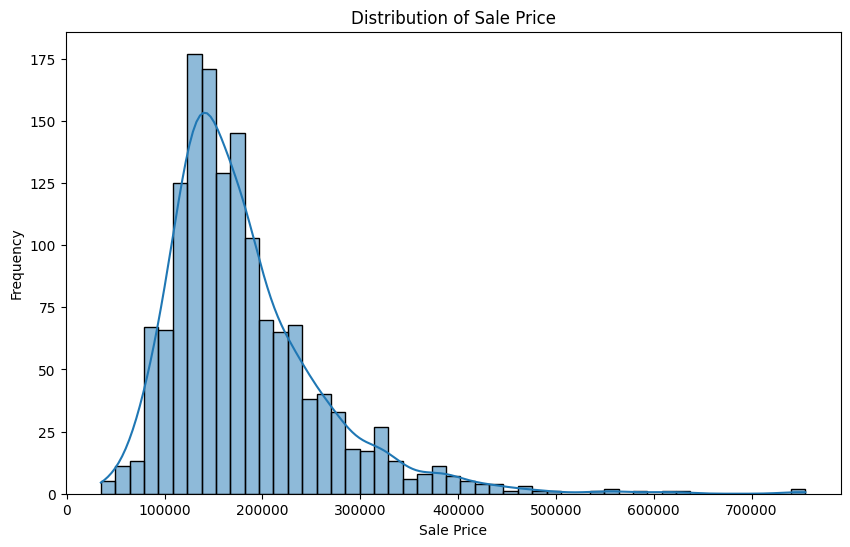


Top 10 correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [34]:
import seaborn as sns

# Display basic information about the datasets
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

# Display summary statistics for numerical columns in the training data
print("\nSummary statistics for numerical columns in training data:")
print(train.describe())

# Check for missing values in both datasets
print("\nMissing values in train dataset:")
print(train.isnull().sum().sort_values(ascending=False)[:20])  # Show top 20 columns with missing values

print("\nMissing values in test dataset:")
print(test.isnull().sum().sort_values(ascending=False)[:20])  # Show top 20 columns with missing values

# Display distribution of the target variable (SalePrice)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

# Show correlation with the target variable
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
correlations = train[numeric_columns].corr()['SalePrice'].sort_values(ascending=False)
print("\nTop 10 correlations with SalePrice:")
print(correlations[:11])  # Including SalePrice itself

In [35]:
train.drop(columns=['Id'], inplace=True)
test_ids = test['Id']
test.drop(columns=['Id'], inplace=True)

# Check for missing values
missing = train.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0].head(10))


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
dtype: int64


In [36]:
# For numeric: fill with median
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

# For categorical: fill with mode
for col in train.select_dtypes(include='object').columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)


C:\Users\46762\AppData\Local\Temp\ipykernel_15796\550137679.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\46762\AppData\Local\Temp\ipykernel_15796\550137679.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

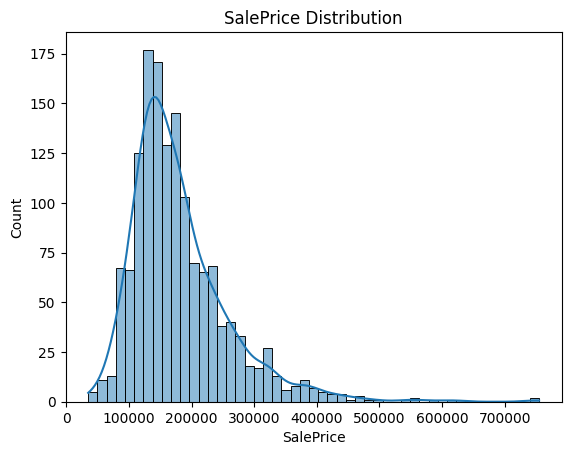

<Axes: >

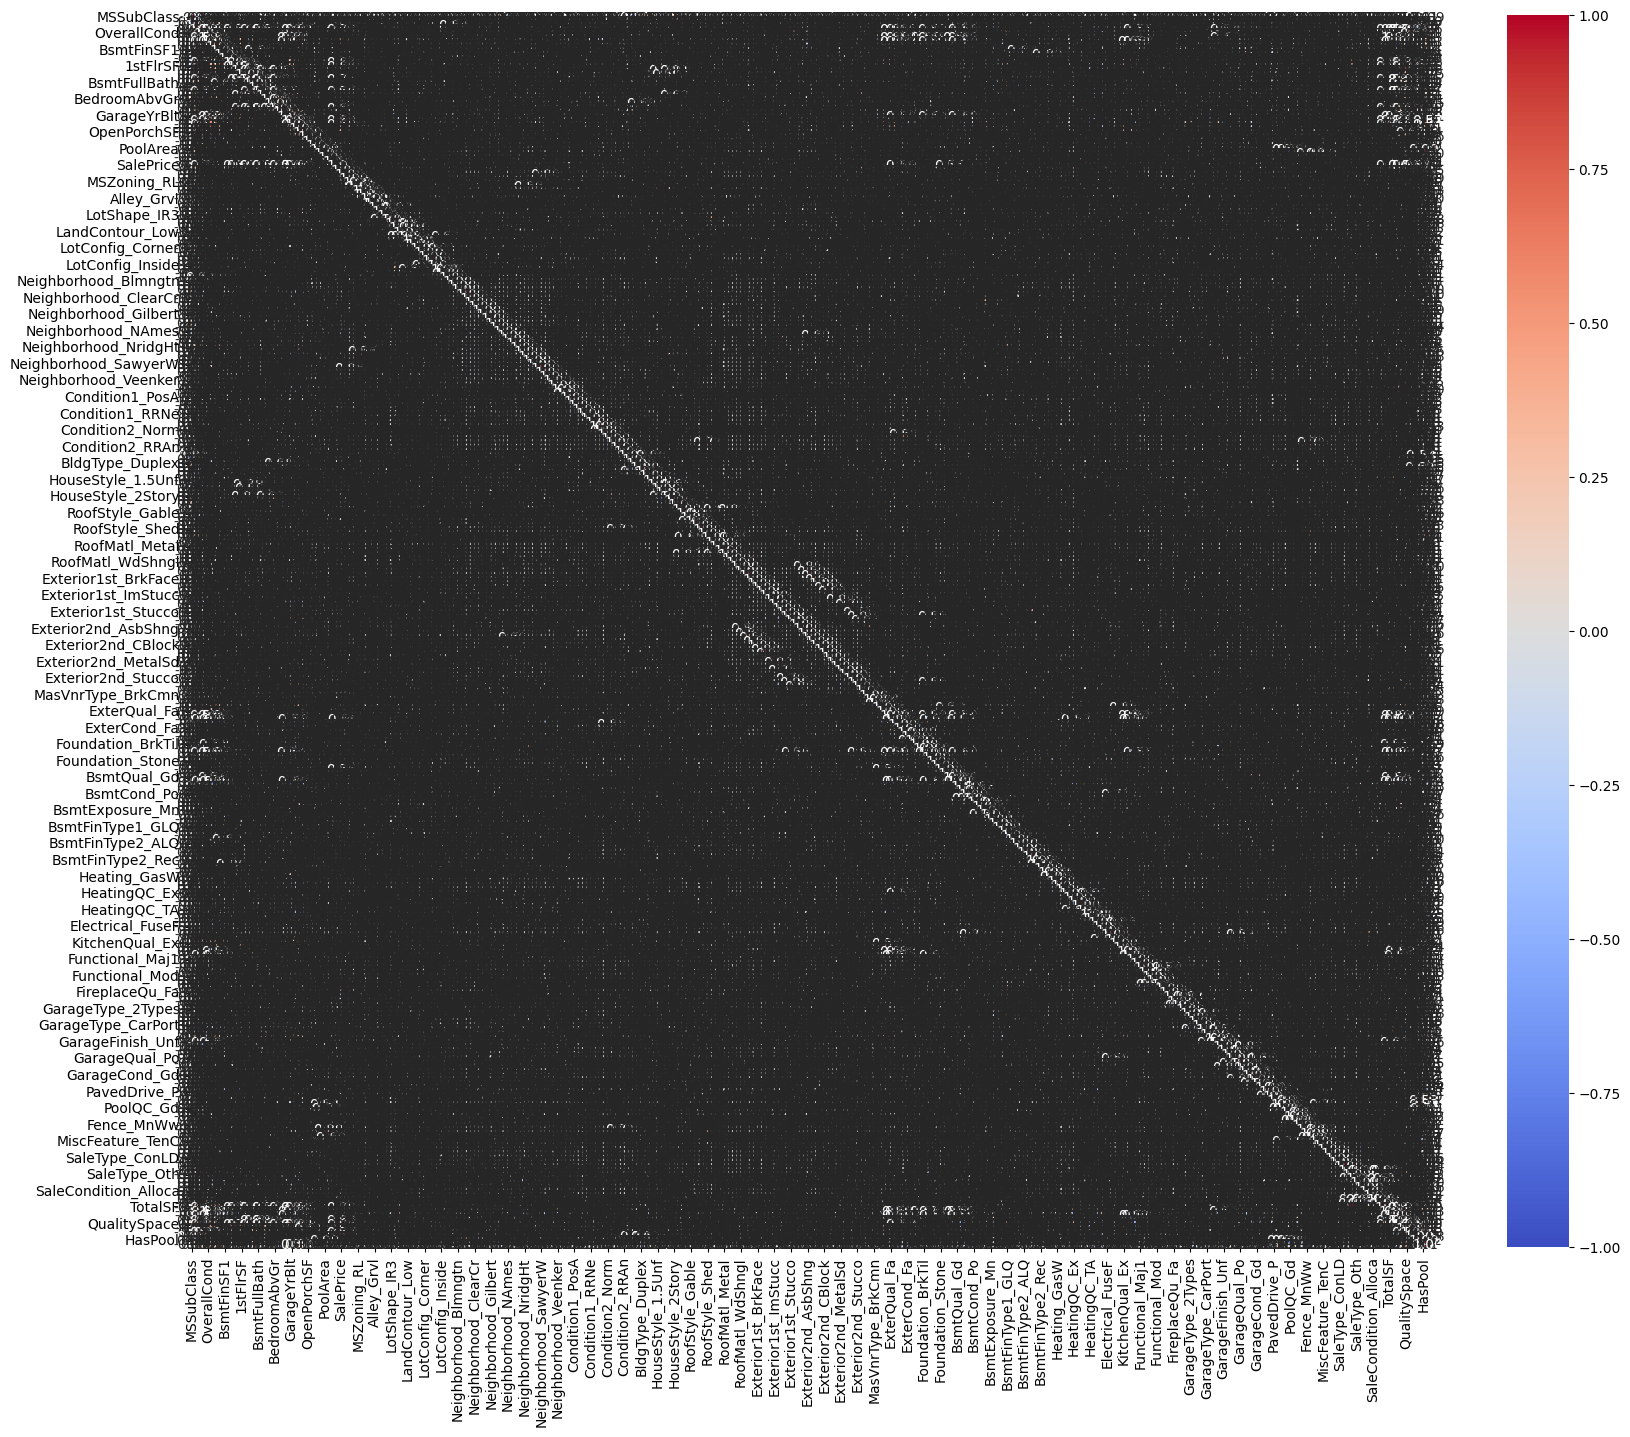

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()

# Correlation matrix
corr = train.corr(numeric_only=True)
plt.figure(figsize=(20,16))  # Increased size significantly
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')


In [38]:
# One-hot encode categoricals
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align train and test columns
train, test = train.align(test, join='left', axis=1)
test.fillna(0, inplace=True)  # Just in case


In [39]:
from sklearn.model_selection import train_test_split

X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
print(f'Validation RMSE: {rmse:.2f}')


Validation RMSE: 28876.49


### Explanation of Engineered Features

1. **Age**: Age of the house at the time of sale (`YrSold - YearBuilt`).
2. **RemodAge**: Years since last remodeling (`YrSold - YearRemodAdd`).
3. **TotalBaths**: Total bathrooms, including fractional values for half baths.
4. **QualitySpace**: Interaction of overall quality and total square footage (`OverallQual * TotalSF`).
5. **TotalPorchSF**: Total porch area (`OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch`).
6. **QualCond**: Interaction of overall quality and condition (`OverallQual * OverallCond`).
7. **RoomDensity**: Rooms above ground per lot area (`TotRmsAbvGrd / LotArea`).
8. **HasPool**: Binary feature indicating if the house has a pool (`PoolArea > 0`).
9. **HasGarage**: Binary feature indicating if the house has a garage (`GarageArea > 0`).

These features capture additional relationships and interactions to improve model performance.

In [41]:
# Feature engineering for total square footage
train['TotalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']

# Add more engineered features
train['Age'] = train['YrSold'] - train['YearBuilt']
test['Age'] = test['YrSold'] - test['YearBuilt']

# Years since remodeling
train['RemodAge'] = train['YrSold'] - train['YearRemodAdd']
test['RemodAge'] = test['YrSold'] - test['YearRemodAdd']

# Total bathrooms (fractional to account for half baths)
train['TotalBaths'] = train['FullBath'] + 0.5*train['HalfBath'] + train['BsmtFullBath'] + 0.5*train['BsmtHalfBath']
test['TotalBaths'] = test['FullBath'] + 0.5*test['HalfBath'] + test['BsmtFullBath'] + 0.5*test['BsmtHalfBath']

# Interaction terms (multiply related features)
train['QualitySpace'] = train['OverallQual'] * train['TotalSF']
test['QualitySpace'] = test['OverallQual'] * test['TotalSF']

# Additional features
# Total porch area
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

# Quality and condition interaction
train['QualCond'] = train['OverallQual'] * train['OverallCond']
test['QualCond'] = test['OverallQual'] * test['OverallCond']



# Total rooms above ground to lot ratio (density)
train['RoomDensity'] = train['TotRmsAbvGrd'] / train['LotArea']
test['RoomDensity'] = test['TotRmsAbvGrd'] / test['LotArea']

# Has pool or not (binary feature)
train['HasPool'] = (train['PoolArea'] > 0).astype(int)
test['HasPool'] = (test['PoolArea'] > 0).astype(int)

# Has garage or not (binary feature)
train['HasGarage'] = (train['GarageArea'] > 0).astype(int)
test['HasGarage'] = (test['GarageArea'] > 0).astype(int)

# Try log transformation on target variable
import numpy as np
y_log = np.log1p(y)

# Make sure all engineered features from cell 14 are included before feature selection
# Re-run feature selection with Random Forest importance after feature engineering
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

# Print top 20 features for inspection
print("Top 20 features by importance:")
print(importances.head(20))

# Select top features for model training
top_features = importances.head(50)['feature'].tolist()

# Check if our engineered features made it to the top features
# If not, add important engineered features explicitly
important_engineered = ['TotalSF', 'Age', 'RemodAge', 'TotalBaths', 
                       'QualitySpace', 'TotalPorchSF', 'QualCond']
                       
for feature in important_engineered:
    if feature in X_train.columns and feature not in top_features:
        top_features.append(feature)
        print(f"Added engineered feature: {feature}")

# Train with only selected features
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]

print(f"\nTotal features selected: {len(top_features)}")

Top 20 features by importance:
              feature  importance
3         OverallQual    0.555692
15          GrLivArea    0.121131
13           2ndFlrSF    0.034455
11        TotalBsmtSF    0.034431
8          BsmtFinSF1    0.028409
12           1stFlrSF    0.025314
2             LotArea    0.017170
26         GarageArea    0.016087
25         GarageCars    0.011747
5           YearBuilt    0.011166
1         LotFrontage    0.008620
247  GarageFinish_Unf    0.006694
22       TotRmsAbvGrd    0.006563
6        YearRemodAdd    0.006470
28        OpenPorchSF    0.006259
18           FullBath    0.006012
24        GarageYrBlt    0.005661
181       BsmtQual_Ex    0.005162
10          BsmtUnfSF    0.004859
27         WoodDeckSF    0.004168

Total features selected: 50


In [42]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(
    RandomForestRegressor(n_estimators=100, random_state=42),
    X_train_selected, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Convert negative RMSE to positive
cv_rmse = -cv_scores
print(f'Cross-Validation RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}')

Cross-Validation RMSE: 30457.83 ± 5106.85


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train model with log-transformed target
model_log = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
model_log.fit(X_train_selected, np.log1p(y_train))

# Make predictions and transform back
y_pred_log = np.expm1(model_log.predict(X_val_selected))
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log))  # Manually calculate RMSE
mae_log = mean_absolute_error(y_val, y_pred_log)
r2_log = r2_score(y_val, y_pred_log)

print(f'RMSE with log transformation: {rmse_log:.2f}')
print(f'MAE with log transformation: {mae_log:.2f}')
print(f'R² with log transformation: {r2_log:.4f}')

# Compare with previous non-transformed model
print('\nComparison with non-transformed model:')
print(f'Previous RMSE: {cv_rmse.mean():.2f}')
print(f'Improvement: {cv_rmse.mean() - rmse_log:.2f} ({(cv_rmse.mean() - rmse_log) / cv_rmse.mean() * 100:.2f}%)')

# Get the feature importances from the log-transformed model
log_importances = pd.DataFrame({
    'feature': X_train_selected.columns,
    'importance': model_log.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10 features
print('\nTop 10 features in log-transformed model:')
print(log_importances.head(10))

RMSE with log transformation: 29148.61
MAE with log transformation: 17230.73
R² with log transformation: 0.8892

Comparison with non-transformed model:
Previous RMSE: 30457.83
Improvement: 1309.22 (4.30%)

Top 10 features in log-transformed model:
        feature  importance
0   OverallQual    0.552410
1     GrLivArea    0.119548
3   TotalBsmtSF    0.045174
8    GarageCars    0.039756
7    GarageArea    0.028065
4    BsmtFinSF1    0.022598
5      1stFlrSF    0.020576
6       LotArea    0.016641
9     YearBuilt    0.016093
21  OverallCond    0.011247


Predictions saved to submission.csv


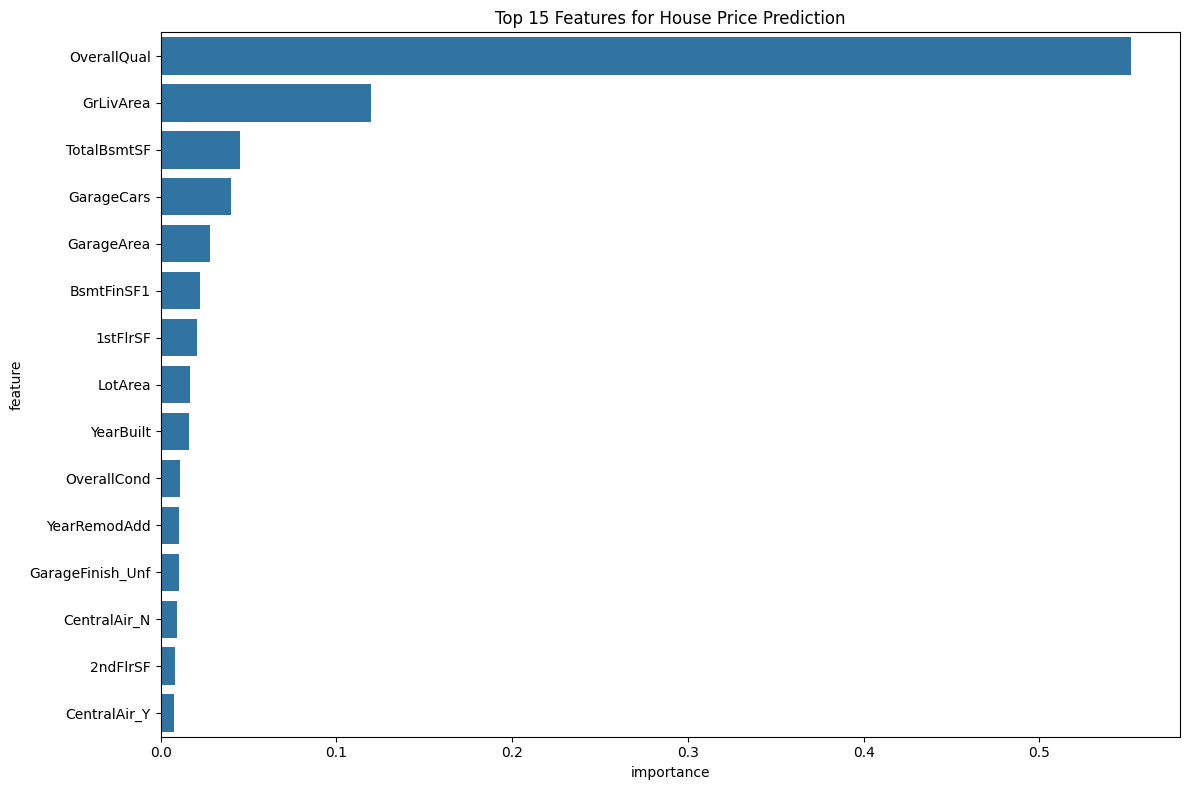

In [44]:
# Apply your best model to make predictions on the test set
test_selected = test[top_features]

# Make sure test data has the same features we added to the training data
test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']
test_selected = test[top_features]  # Reselect after adding features

# Use log-transformed model for final predictions
final_predictions = np.expm1(model_log.predict(test_selected))

# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})
submission.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

# Visualize the most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=log_importances.head(15))
plt.title('Top 15 Features for House Price Prediction')
plt.tight_layout()
plt.show()

In [45]:
print(train.columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'TotalSF', 'Age', 'RemodAge', 'TotalBaths', 'QualitySpace',
       'TotalPorchSF', 'QualCond', 'RoomDensity', 'HasPool', 'HasGarage'],
      dtype='object', length=298)


### Explanation of Engineered Features

1. **Age**: Age of the house at the time of sale (`YrSold - YearBuilt`).
2. **RemodAge**: Years since last remodeling (`YrSold - YearRemodAdd`).
3. **TotalBaths**: Total bathrooms, including fractional values for half baths.
4. **QualitySpace**: Interaction of overall quality and total square footage (`OverallQual * TotalSF`).
5. **TotalPorchSF**: Total porch area (`OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch`).
6. **QualCond**: Interaction of overall quality and condition (`OverallQual * OverallCond`).
7. **RoomDensity**: Rooms above ground per lot area (`TotRmsAbvGrd / LotArea`).
8. **HasPool**: Binary feature indicating if the house has a pool (`PoolArea > 0`).
9. **HasGarage**: Binary feature indicating if the house has a garage (`GarageArea > 0`).

These features capture additional relationships and interactions to improve model performance.

In [46]:
# These models don't require extra packages
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet

# Try Gradient Boosting (similar to XGBoost)
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4, 
    min_samples_split=5,
    random_state=42
)
gb_model.fit(X_train_selected, np.log1p(y_train))
y_pred_gb = np.expm1(gb_model.predict(X_val_selected))
r2_gb = r2_score(y_val, y_pred_gb)
print(f'GradientBoosting R²: {r2_gb:.4f}')

GradientBoosting R²: 0.8792


In [47]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForest
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with log-transformed target
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

rf_grid.fit(X_train_selected, np.log1p(y_train))
print(f"Best parameters: {rf_grid.best_params_}")

# Use best model
best_rf = rf_grid.best_estimator_
y_pred_best = np.expm1(best_rf.predict(X_val_selected))
r2_best = r2_score(y_val, y_pred_best)
print(f'Best RF model R²: {r2_best:.4f}')

Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best RF model R²: 0.8834


In [48]:
# Identify outliers in the training data
from scipy import stats

z_scores = stats.zscore(y_train)
outlier_indices = np.abs(z_scores) > 3

# Train model without outliers
X_train_no_outliers = X_train_selected[~outlier_indices]
y_train_no_outliers = y_train[~outlier_indices]

model_no_outliers = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20,
    random_state=42
)
model_no_outliers.fit(X_train_no_outliers, np.log1p(y_train_no_outliers))
y_pred_no_outliers = np.expm1(model_no_outliers.predict(X_val_selected))
r2_no_outliers = r2_score(y_val, y_pred_no_outliers)
print(f'R² without outliers: {r2_no_outliers:.4f}')

R² without outliers: 0.7942


LINJÄR

In [49]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_val)
rmse_linear = np.sqrt(mean_squared_error(y_val, y_pred_linear))
r2_linear = r2_score(y_val, y_pred_linear)
print(f'Linear Regression RMSE: {rmse_linear:.2f}')
print(f'Linear Regression R²: {r2_linear:.4f}')

# Compare with other models
print('\nModel Performance Comparison (R²):')
print(f'Linear Regression: {r2_linear:.4f}')
print(f'Random Forest: {r2_best:.4f}')
print(f'Gradient Boosting: {r2_gb:.4f}')
print(f'Model without outliers: {r2_no_outliers:.4f}')

Linear Regression RMSE: 29557.71
Linear Regression R²: 0.8861

Model Performance Comparison (R²):
Linear Regression: 0.8861
Random Forest: 0.8834
Gradient Boosting: 0.8792
Model without outliers: 0.7942


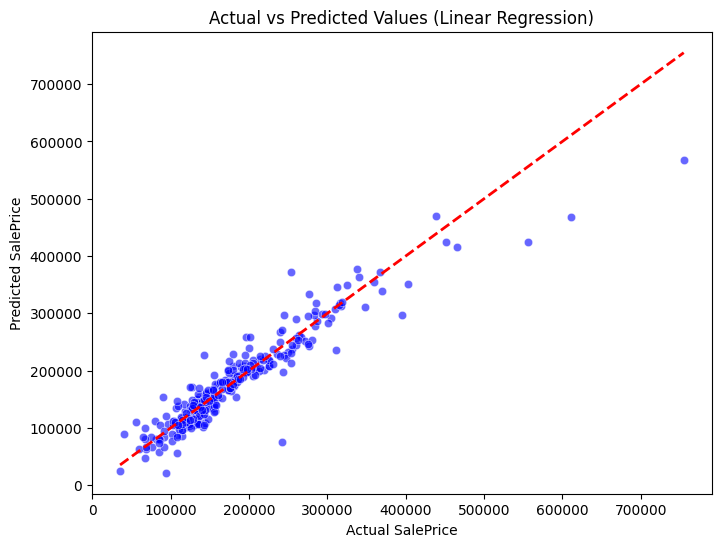

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_linear, alpha=0.6, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Values (Linear Regression)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

C:\Users\46762\AppData\Local\Temp\ipykernel_15796\2859800164.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_scores, palette='coolwarm')


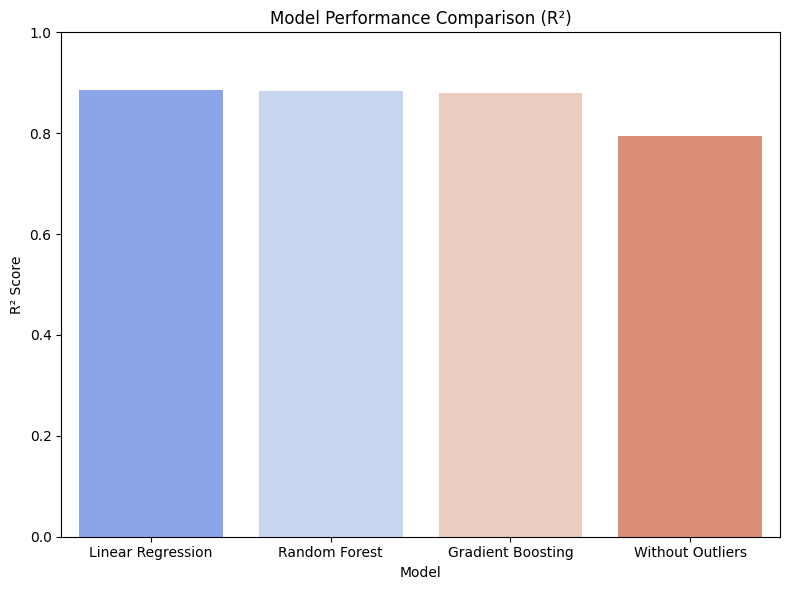

In [51]:
# Model performance metrics
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Without Outliers']
r2_scores = [r2_linear, r2_best, r2_gb, r2_no_outliers]

# Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=r2_scores, palette='coolwarm')
plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.tight_layout()
plt.show()

TESTER MED PCA O UMAP O DATAREDUKTION


In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Apply PCA
pca = PCA(n_components=10)  # Reduce to 10 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Train a model on PCA-reduced data
linear_model_pca = LinearRegression()
linear_model_pca.fit(X_train_pca, y_train)
y_pred_pca = linear_model_pca.predict(X_val_pca)

# Evaluate the model
rmse_pca = np.sqrt(mean_squared_error(y_val, y_pred_pca))
r2_pca = r2_score(y_val, y_pred_pca)

print(f"PCA - Linear Regression RMSE: {rmse_pca:.2f}")
print(f"PCA - Linear Regression R²: {r2_pca:.4f}")

PCA - Linear Regression RMSE: 34348.81
PCA - Linear Regression R²: 0.8462


In [53]:
# Install UMAP if not already installed
try:
    import umap
except ImportError:
    print("UMAP is not installed. Install it using: pip install umap-learn")

from umap import UMAP

# Apply UMAP
umap_reducer = UMAP(n_components=10, random_state=42)  # Reduce to 10 components
X_train_umap = umap_reducer.fit_transform(X_train_scaled)
X_val_umap = umap_reducer.transform(X_val_scaled)

# Train a model on UMAP-reduced data
linear_model_umap = LinearRegression()
linear_model_umap.fit(X_train_umap, y_train)
y_pred_umap = linear_model_umap.predict(X_val_umap)

# Evaluate the model
rmse_umap = np.sqrt(mean_squared_error(y_val, y_pred_umap))
r2_umap = r2_score(y_val, y_pred_umap)

print(f"UMAP - Linear Regression RMSE: {rmse_umap:.2f}")
print(f"UMAP - Linear Regression R²: {r2_umap:.4f}")

c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP - Linear Regression RMSE: 52993.78
UMAP - Linear Regression R²: 0.6339


In [54]:
# Compare results with and without dimensionality reduction
print("\nComparison of Model Performance:")
print(f"Original Data - Linear Regression R²: {r2_linear:.4f}")
print(f"PCA Reduced Data - Linear Regression R²: {r2_pca:.4f}")
print(f"UMAP Reduced Data - Linear Regression R²: {r2_umap:.4f}")


Comparison of Model Performance:
Original Data - Linear Regression R²: 0.8861
PCA Reduced Data - Linear Regression R²: 0.8462
UMAP Reduced Data - Linear Regression R²: 0.6339


BÄTTRE MED ORIGINAL DATA UTAN REDUKTION


c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP + K-Means + PCA - Linear Regression R²: 0.6070, RMSE: 54902.76
UMAP + K-Means + PCA - Random Forest R²: 0.7209, RMSE: 46265.19
UMAP + K-Means + PCA - Gradient Boosting R²: 0.7244, RMSE: 45974.64

Comparison with previous models:
Original Data - Linear Regression R²: 0.8861
PCA Reduced Data - Linear Regression R²: 0.8462
UMAP Reduced Data - Linear Regression R²: 0.6339
Random Forest (best) R²: 0.8834
Gradient Boosting R²: 0.7244


C:\Users\46762\AppData\Local\Temp\ipykernel_15796\3231239977.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_scores, palette='viridis')


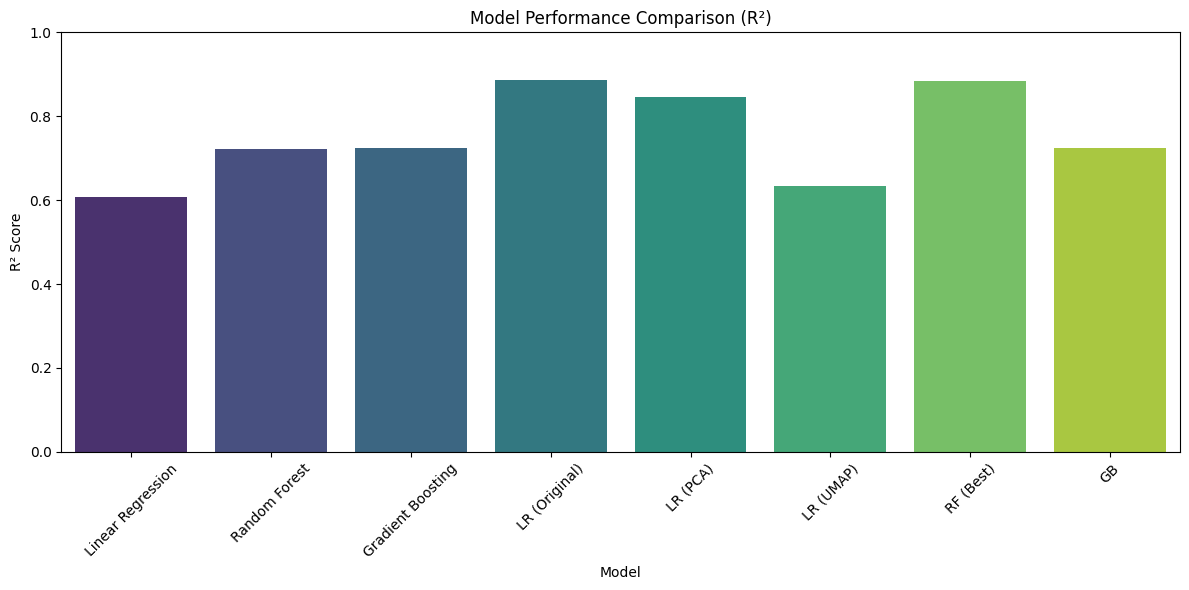

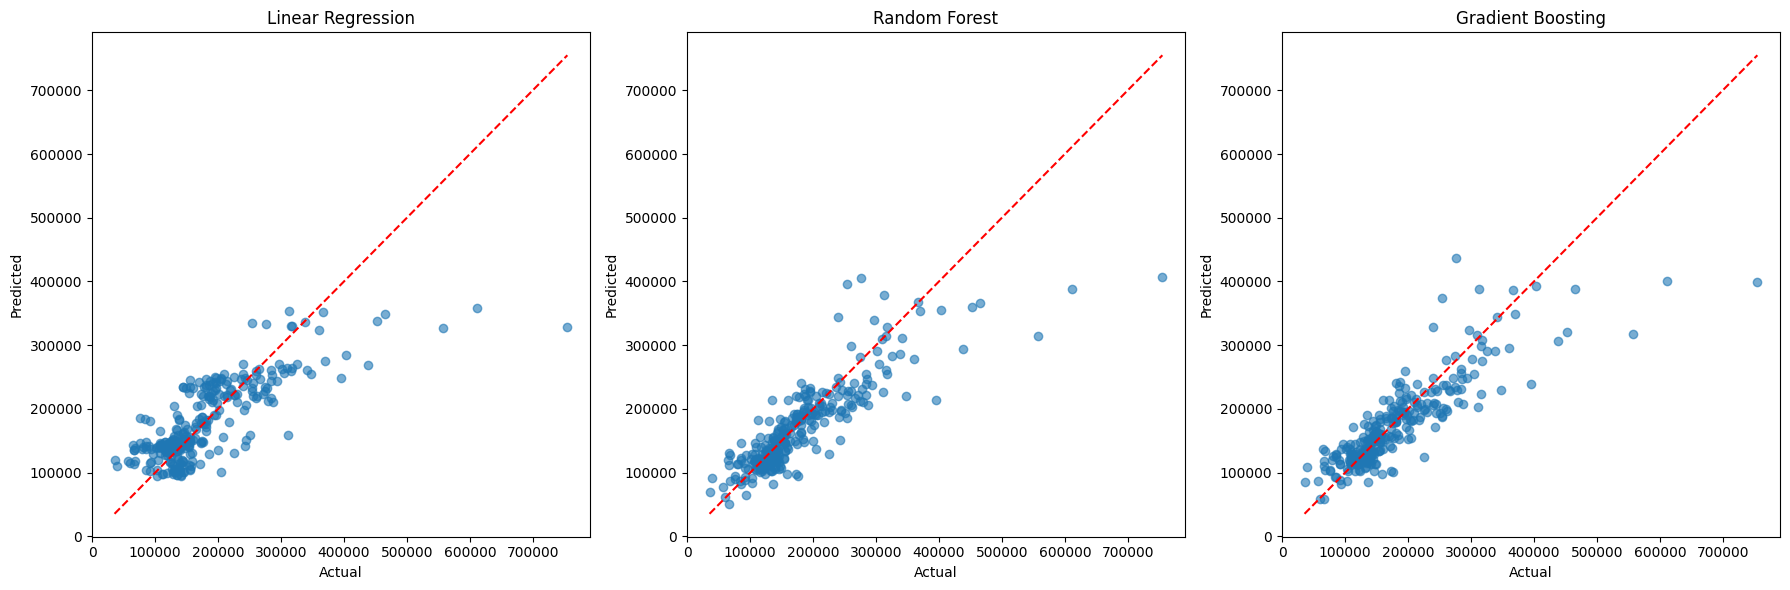

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns
import umap

import matplotlib.pyplot as plt

# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Step 2: Apply UMAP for dimensionality reduction
n_components_umap = 10
umap_reducer = umap.UMAP(n_components=n_components_umap, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train_scaled)
X_val_umap = umap_reducer.transform(X_val_scaled)

# Step 3: Apply K-Means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train_umap)
val_clusters = kmeans.predict(X_val_umap)

# Step 4: Apply PCA to further reduce dimensions 
n_components_pca = 5
pca = PCA(n_components=n_components_pca)
X_train_umap_pca = pca.fit_transform(X_train_umap)
X_val_umap_pca = pca.transform(X_val_umap)

# Step 5: Add cluster information as features
X_train_with_clusters = np.column_stack((X_train_umap_pca, train_clusters))
X_val_with_clusters = np.column_stack((X_val_umap_pca, val_clusters))

# Step 6: Train multiple models and compare performance
# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

# Train and evaluate Linear Regression
lr_model.fit(X_train_with_clusters, y_train)
y_pred_lr = lr_model.predict(X_val_with_clusters)
r2_lr = r2_score(y_val, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))

# Train and evaluate Random Forest with log transformation
rf_model.fit(X_train_with_clusters, np.log1p(y_train))
y_pred_rf = np.expm1(rf_model.predict(X_val_with_clusters))
r2_rf = r2_score(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

# Train and evaluate Gradient Boosting
gb_model.fit(X_train_with_clusters, y_train)
y_pred_gb = gb_model.predict(X_val_with_clusters)
r2_gb = r2_score(y_val, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))

# Display results
print(f"UMAP + K-Means + PCA - Linear Regression R²: {r2_lr:.4f}, RMSE: {rmse_lr:.2f}")
print(f"UMAP + K-Means + PCA - Random Forest R²: {r2_rf:.4f}, RMSE: {rmse_rf:.2f}")
print(f"UMAP + K-Means + PCA - Gradient Boosting R²: {r2_gb:.4f}, RMSE: {rmse_gb:.2f}")

# Compare with previous models
print("\nComparison with previous models:")
print(f"Original Data - Linear Regression R²: {r2_linear:.4f}")
print(f"PCA Reduced Data - Linear Regression R²: {r2_pca:.4f}")
print(f"UMAP Reduced Data - Linear Regression R²: {r2_umap:.4f}")
print(f"Random Forest (best) R²: {r2_best:.4f}")
print(f"Gradient Boosting R²: {r2_gb:.4f}")

# Visualize results
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 
          'LR (Original)', 'LR (PCA)', 'LR (UMAP)', 'RF (Best)', 'GB']
r2_scores = [r2_lr, r2_rf, r2_gb, r2_linear, r2_pca, r2_umap, r2_best, r2_gb]

plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plots for model predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear Regression
axes[0].scatter(y_val, y_pred_lr, alpha=0.6)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Random Forest
axes[1].scatter(y_val, y_pred_rf, alpha=0.6)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Gradient Boosting
axes[2].scatter(y_val, y_pred_gb, alpha=0.6)
axes[2].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axes[2].set_title('Gradient Boosting')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [56]:
from sklearn.neighbors import KNeighborsRegressor

# Train a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_val_selected)
rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn))
r2_knn = r2_score(y_val, y_pred_knn)

print(f"KNN RMSE: {rmse_knn:.2f}")
print(f"KNN R²: {r2_knn:.4f}")

KNN RMSE: 47313.99
KNN R²: 0.7081


In [57]:
from sklearn.ensemble import StackingRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]

# Train a stacking regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
stacking_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_stacking = stacking_model.predict(X_val_selected)
rmse_stacking = np.sqrt(mean_squared_error(y_val, y_pred_stacking))
r2_stacking = r2_score(y_val, y_pred_stacking)

print(f"Stacking Regressor RMSE: {rmse_stacking:.2f}")
print(f"Stacking Regressor R²: {r2_stacking:.4f}")

Stacking Regressor RMSE: 26921.33
Stacking Regressor R²: 0.9055


In [58]:
from sklearn.linear_model import ElasticNet

# Train an ElasticNet model
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elasticnet_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_elasticnet = elasticnet_model.predict(X_val_selected)
rmse_elasticnet = np.sqrt(mean_squared_error(y_val, y_pred_elasticnet))
r2_elasticnet = r2_score(y_val, y_pred_elasticnet)

print(f"ElasticNet RMSE: {rmse_elasticnet:.2f}")
print(f"ElasticNet R²: {r2_elasticnet:.4f}")

ElasticNet RMSE: 33421.63
ElasticNet R²: 0.8544


c:\Users\46762\VSCODE\AI_kurs\grupp_uppgift_2\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.959e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


In [59]:
from catboost import CatBoostRegressor

# Train a CatBoost model
catboost_model = CatBoostRegressor(iterations=300, learning_rate=0.05, depth=4, random_state=42, verbose=0)
catboost_model.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred_catboost = catboost_model.predict(X_val_selected)
rmse_catboost = np.sqrt(mean_squared_error(y_val, y_pred_catboost))
r2_catboost = r2_score(y_val, y_pred_catboost)

print(f"CatBoost RMSE: {rmse_catboost:.2f}")
print(f"CatBoost R²: {r2_catboost:.4f}")

CatBoost RMSE: 27756.75
CatBoost R²: 0.8996



Training on Original dataset:
Linear Regression (Original) - RMSE: 29557.71, R²: 0.8861
Random Forest (Original) - RMSE: 28735.77, R²: 0.8923
Gradient Boosting (Original) - RMSE: 25860.24, R²: 0.9128
CatBoost (Original) - RMSE: 27056.22, R²: 0.9046

Training on PCA dataset:
Linear Regression (PCA) - RMSE: 34348.81, R²: 0.8462
Random Forest (PCA) - RMSE: 30497.55, R²: 0.8787
Gradient Boosting (PCA) - RMSE: 28914.48, R²: 0.8910
CatBoost (PCA) - RMSE: 31047.13, R²: 0.8743

Training on UMAP dataset:
Linear Regression (UMAP) - RMSE: 52993.78, R²: 0.6339
Random Forest (UMAP) - RMSE: 42888.93, R²: 0.7602
Gradient Boosting (UMAP) - RMSE: 42524.59, R²: 0.7642
CatBoost (UMAP) - RMSE: 42204.45, R²: 0.7678

Training on PCA + K-Means + UMAP dataset:
Linear Regression (PCA + K-Means + UMAP) - RMSE: 54902.76, R²: 0.6070
Random Forest (PCA + K-Means + UMAP) - RMSE: 45416.51, R²: 0.7311
Gradient Boosting (PCA + K-Means + UMAP) - RMSE: 45974.64, R²: 0.7244
CatBoost (PCA + K-Means + UMAP) - RMSE: 44993.

C:\Users\46762\AppData\Local\Temp\ipykernel_15796\3646906950.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')


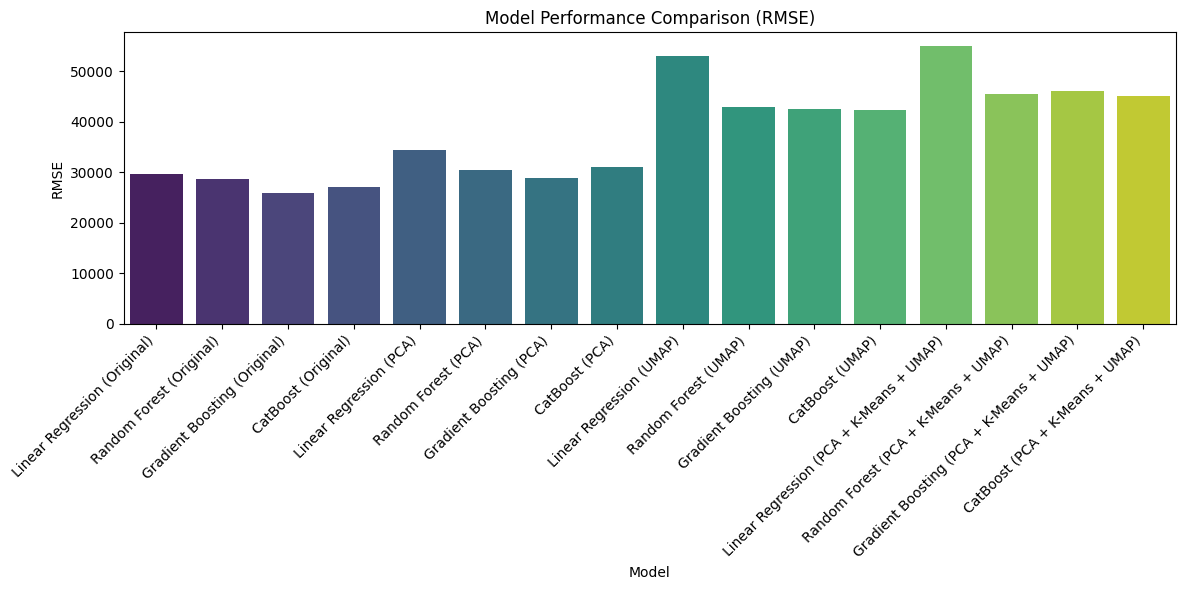

C:\Users\46762\AppData\Local\Temp\ipykernel_15796\3646906950.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R²', palette='coolwarm')


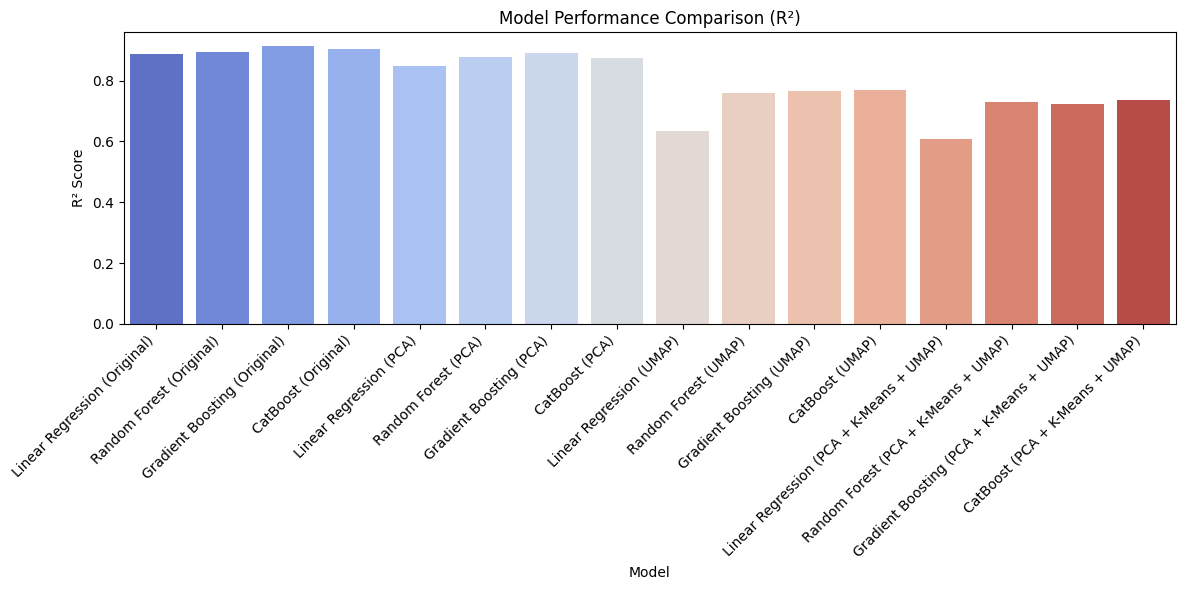

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to train and evaluate models
def train_and_evaluate(model, X_train, X_val, y_train, y_val, model_name, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    results.append({'Model': model_name, 'RMSE': rmse, 'R²': r2})
    print(f"{model_name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Prepare datasets
datasets = {
    "Original": (X_train, X_val),
    "PCA": (X_train_pca, X_val_pca),
    "UMAP": (X_train_umap, X_val_umap),
    "PCA + K-Means + UMAP": (X_train_with_clusters, X_val_with_clusters)
}

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, learning_rate=0.05, depth=4, random_state=42, verbose=0)
}

# Train and evaluate models on all datasets
results = []
for dataset_name, (X_train_set, X_val_set) in datasets.items():
    print(f"\nTraining on {dataset_name} dataset:")
    for model_name, model in models.items():
        train_and_evaluate(model, X_train_set, X_val_set, y_train, y_val, f"{model_name} ({dataset_name})", results)

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')
plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='R²', palette='coolwarm')
plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Performing 5-fold CV on Original dataset:
Linear Regression - Mean RMSE: 34597.56, Std RMSE: 9361.65
Random Forest - Mean RMSE: 30446.80, Std RMSE: 4896.41
Gradient Boosting - Mean RMSE: 29169.01, Std RMSE: 4481.73
CatBoost - Mean RMSE: 28117.55, Std RMSE: 4351.03

Performing 5-fold CV on PCA dataset:
Linear Regression - Mean RMSE: 34352.66, Std RMSE: 8161.98
Random Forest - Mean RMSE: 32037.10, Std RMSE: 5477.48
Gradient Boosting - Mean RMSE: 32754.47, Std RMSE: 6103.12
CatBoost - Mean RMSE: 31965.18, Std RMSE: 5558.26

Performing 5-fold CV on UMAP + K-Means dataset:
Linear Regression - Mean RMSE: 48789.03, Std RMSE: 4377.23
Random Forest - Mean RMSE: 38679.93, Std RMSE: 4798.43
Gradient Boosting - Mean RMSE: 41168.22, Std RMSE: 4734.01
CatBoost - Mean RMSE: 41376.32, Std RMSE: 5188.12


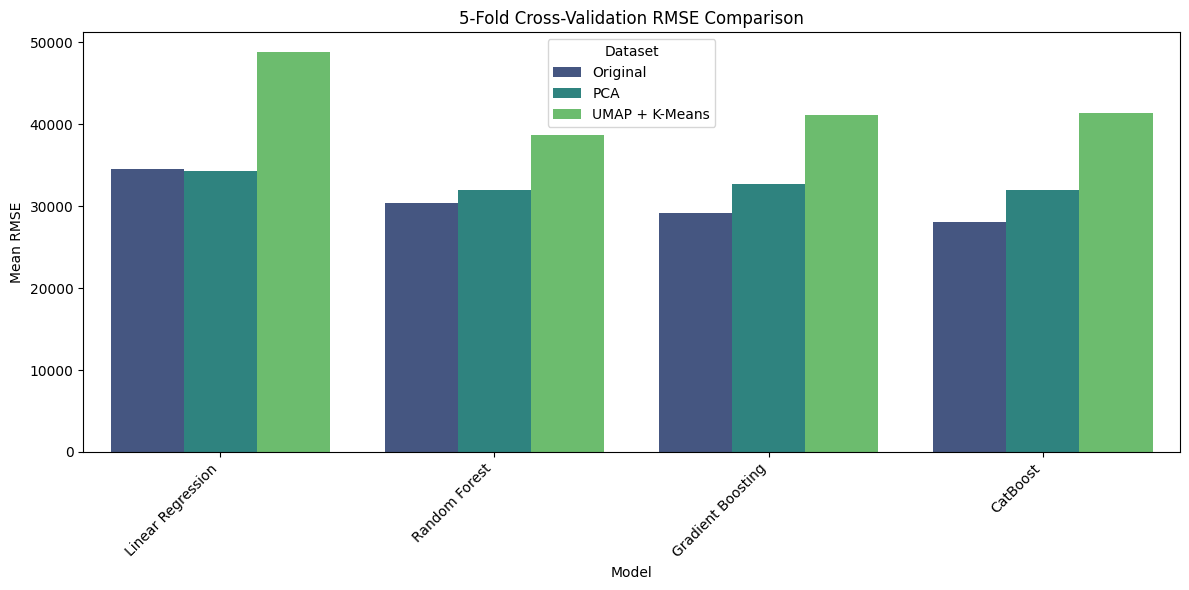

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define RMSE function manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a custom scorer without the squared parameter
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Prepare datasets
datasets = {
    "Original": (X_train_selected, y_train),
    "PCA": (X_train_pca, y_train),
    "UMAP + K-Means": (X_train_with_clusters, y_train)
}

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, learning_rate=0.05, depth=4, random_state=42, verbose=0)
}

# Perform 5-fold cross-validation
results = []
for dataset_name, (X, y) in datasets.items():
    print(f"\nPerforming 5-fold CV on {dataset_name} dataset:")
    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer)
        # Since our scorer returns negative values (greater_is_better=False), we negate to get actual RMSE
        cv_scores = -cv_scores
        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Mean RMSE": np.mean(cv_scores),
            "Std RMSE": np.std(cv_scores)
        })
        print(f"{model_name} - Mean RMSE: {np.mean(cv_scores):.2f}, Std RMSE: {np.std(cv_scores):.2f}")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Mean RMSE', hue='Dataset', palette='viridis')
plt.title("5-Fold Cross-Validation RMSE Comparison")
plt.ylabel("Mean RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

Original Dataset:

All models achieve their best performance on the original dataset
Tree-based models (Random Forest, Gradient Boosting, CatBoost) handle the high dimensionality well
The complex relationships in the data are best captured with the full feature set

PCA Reduction:

Moderate drop in performance across all models
Linear Regression suffers less from PCA reduction than from UMAP reduction
PCA preserves linear relationships but loses some non-linear patterns important for tree-based models

UMAP + K-Means:

Significant performance degradation for all models
Linear Regression shows the most dramatic drop in performance
The non-linear dimensionality reduction combined with clustering loses too much information